<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [226]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [227]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-13 10:54:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-12-13 10:54:59 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [228]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [229]:
df.shape

(346, 10)

### Convert to date time object 

In [230]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [231]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [232]:
# notice: installing seaborn might takes a few minutes
!pip install -c anaconda seaborn -y


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


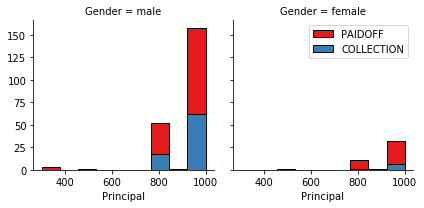

In [233]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

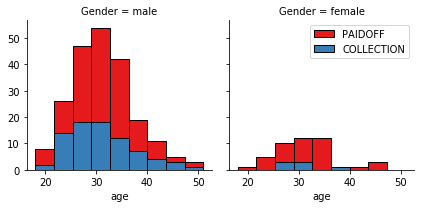

In [234]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

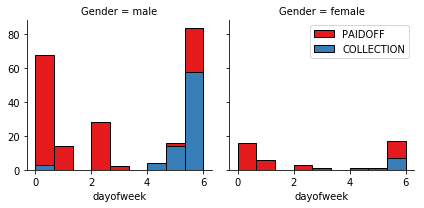

In [235]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [236]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [237]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [238]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [239]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [240]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [241]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [242]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [243]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

**We will normalise data after train split**

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Train Test Split & Normalization 

We will use the same train/test set split in all the below methods in order to avoid repeating the process

In [244]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [245]:
# normalizing the train dataset
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


array([[ 0.56081126, -0.9677917 ,  0.69858179, -0.40565621, -1.17444044,
        -0.40565621, -0.90321065,  1.21007674],
       [ 0.56081126,  0.9437816 , -0.81959596, -0.40565621,  0.85146932,
        -0.40565621,  1.10716144, -0.82639387],
       [ 0.56081126,  0.9437816 ,  0.02383612, -0.40565621, -1.17444044,
        -0.40565621, -0.90321065,  1.21007674],
       [ 0.56081126, -0.9677917 , -0.98828237, -0.40565621,  0.85146932,
        -0.40565621, -0.90321065,  1.21007674],
       [ 0.56081126,  0.9437816 , -0.48222312, -0.40565621, -1.17444044,
        -0.40565621, -0.90321065,  1.21007674]])

In [246]:
# normalizing the train dataset
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


array([[ 0.33474248,  0.83916906, -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 ,  1.26197963, -1.05887304],
       [-1.70282047, -0.9301633 , -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248, -0.9301633 , -0.04012144, -0.47756693, -1.34164079,
        -0.2773501 ,  1.26197963, -1.05887304],
       [ 0.33474248,  0.83916906, -1.13231619, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248,  0.83916906,  0.42796202, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028]])

### Classification 

In [247]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

### Finding correct K

In [248]:
#We will find the point that a significant change happens to avoid over-fitting

k_range = range(1, 50)
trs = []
ts = []
for k in k_range:
    neigh_K = KNeighborsClassifier(n_neighbors = k)
    neigh_K.fit(X_train, y_train)
    yhat_K = neigh_K.predict(X_test)
    trs.append(jaccard_similarity_score(y_train, neigh_K.predict(X_train)))
    ts.append(jaccard_similarity_score(y_test, yhat_K))

result = pd.DataFrame()
result.insert(loc=0, column='Number of Nabors (K)', value=k_range)
result.insert(loc=1, column='Train Set Accuracy', value=trs)
result.insert(loc=2, column='Test Set Accuracy', value=ts)
result

,Number of Nabors (K),Train Set Accuracy,Test Set Accuracy
0,1,0.898551,0.671429
1,2,0.818841,0.642857
2,3,0.833333,0.728571
3,4,0.815217,0.657143
4,5,0.818841,0.714286
5,6,0.793478,0.657143
6,7,0.811594,0.742857
7,8,0.800725,0.742857
8,9,0.793478,0.714286
9,10,0.782609,0.671429


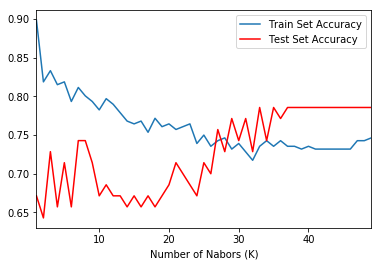

In [249]:
ax = plt.gca()

result.plot(kind='line',x='Number of Nabors (K)',y='Train Set Accuracy',ax=ax)
result.plot(kind='line',x='Number of Nabors (K)',y='Test Set Accuracy', color='red', ax=ax)

plt.show()

We will choose **K=7** since it maximises Test Set Accuracy without over-fitting

### Train KNN Model for K=7

In [250]:
k = 7
neigh_K = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_K = neigh_K.predict(X_test)
print("Training set Accuracy - JACCARD: ", jaccard_similarity_score(y_train, neigh_K.predict(X_train)))
print("Testing set Accuracy - JACCARD: ", jaccard_similarity_score(y_test, yhat_K))

Training set Accuracy - JACCARD:  0.8115942028985508
Testing set Accuracy - JACCARD:  0.7428571428571429


# Decision Tree

### Classification

In [251]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

### Finding Correct Depth

<div id="modeling">
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>LoanStatusTree(Depth)</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.
</div>

In [252]:
d_range = range(1, 20)
trs = []
ts = []
for d in d_range:
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DT.fit(X_train, y_train)
    dt_yhat = DT.predict(X_test)
    trs.append(jaccard_similarity_score(y_train, DT.predict(X_train)))
    ts.append(jaccard_similarity_score(y_test, dt_yhat))

result = pd.DataFrame()
result.insert(loc=0, column='Depth', value=d_range)
result.insert(loc=1, column='Train Set Accuracy', value=trs)
result.insert(loc=2, column='Test Set Accuracy', value=ts)
result



,Depth,Train Set Accuracy,Test Set Accuracy
0,1,0.742754,0.785714
1,2,0.742754,0.785714
2,3,0.746377,0.585714
3,4,0.746377,0.585714
4,5,0.750000,0.614286
5,6,0.775362,0.771429
6,7,0.789855,0.757143
7,8,0.797101,0.757143
8,9,0.829710,0.642857
9,10,0.836957,0.728571


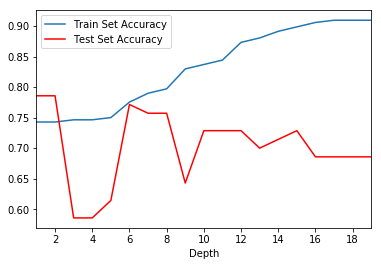

In [253]:
ax = plt.gca()

result.plot(kind='line',x='Depth',y='Train Set Accuracy',ax=ax)
result.plot(kind='line',x='Depth',y='Test Set Accuracy', color='red', ax=ax)

plt.show()

We will choose **depth=6** since it maximises Test set accuracy without overfitting training set

### Train Decision Tree Model for Depth=6

In [254]:
d = 6
DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
DT.fit(X_train, y_train)
dt_yhat = DT.predict(X_test)
print("Training set Accuracy - JACCARD: ", jaccard_similarity_score(y_train, DT.predict(X_train)))
print("Testing set Accuracy - JACCARD: ", jaccard_similarity_score(y_test, dt_yhat))

Training set Accuracy - JACCARD:  0.7753623188405797
Testing set Accuracy - JACCARD:  0.7714285714285715


# Support Vector Machine

The SVM algorithm offers a choice of kernel functions for performing its processing. We will use the 4 most popular and compare their results.  
1.Linear   
2.Polynomial  
3.Radial basis function (RBF)  
4.Sigmoid  

### Classification

In [255]:
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

### Finding correct Kernel function

In [286]:
func_list = ['linear', 'poly', 'rbf', 'sigmoid']
trs = []
ts = []


for func in func_list:
    SVM = svm.SVC(kernel=func)
    SVM.fit(X_train, y_train)
    svm_yhat = SVM.predict(X_test)
    trs.append(f1_score(y_train, SVM.predict(X_train), average='weighted'))
    ts.append(f1_score(y_test, svm_yhat, average='weighted'))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [287]:
T = np.array(trs)
TS = np.array (ts)
T = np.round(T,2)
TS = np.round(TS,2)

In [290]:
SVM_Accuracy = pd.DataFrame({'Kernel Functions' : ['Linear', 'Poly', 'RBF', 'Sigmoid'],'Training set Accuracy': T,
                    'Testing set Accuracy': TS})

SVM_Accuracy.set_index('Kernel Functions', inplace = True)
SVM_Accuracy

,Training set Accuracy,Testing set Accuracy
Kernel Functions,,
Linear,0.63,0.69
Poly,0.74,0.69
RBF,0.77,0.73
Sigmoid,0.63,0.68


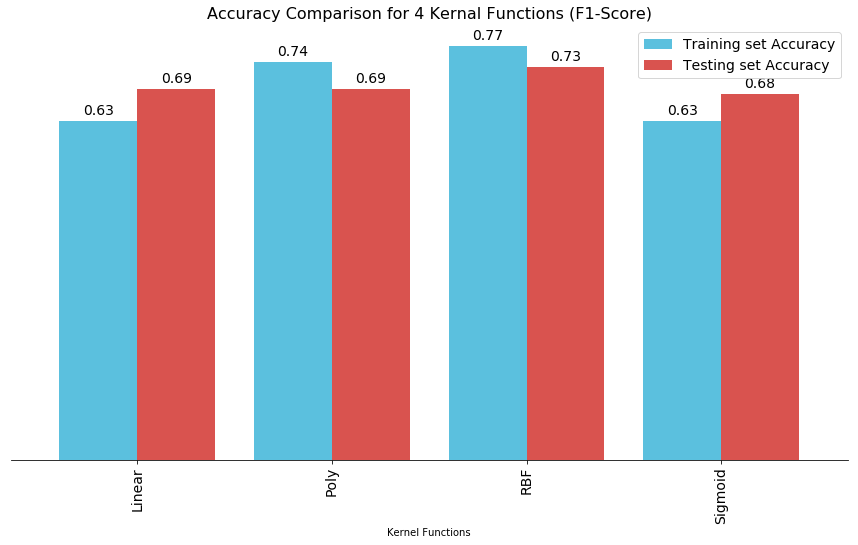

In [291]:
ax = SVM_Accuracy.plot(kind='bar', width=0.8, figsize=(15, 8),  color=['#5bc0de', '#d9534f'])

ax.set_title("Accuracy Comparison for 4 Kernal Functions (F1-Score)", fontsize=16) # add title to the plot
ax.legend(loc='upper right', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=14)
ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
  ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), 
    ha='center',
    va='center',
    xytext=(0, 10),
    textcoords='offset points',
    fontsize = 14
    ),

plt.show()

Polynomial and Radial basis function (RBF) are almost the same. In this case we will use **RBF** for the model

### Train SVM Model using Polynomial kernel

In [293]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train)
SVM_yhat = SVM.predict(X_test)
print("Training set Accuracy - F1-Score: ", jaccard_similarity_score(y_train, SVM.predict(X_train)))
print("Testing set Accuracy - F1-Score: ", jaccard_similarity_score(y_test, SVM_yhat))

Training set Accuracy - F1-Score:  0.782608695652174
Testing set Accuracy - F1-Score:  0.7428571428571429


# Logistic Regression

### Classification

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Finding correct C and Solver

In [262]:
c_param = [0.1, 0.01, 0.001]
solver_param = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
trs = []
ts = []
A = []
B = []

for i, c in enumerate(c_param):
    for j, sol in enumerate(solver_param):
        LR = LogisticRegression(C=c, solver=sol).fit(X_train, y_train)
        lr_yhat = LR.predict(X_test)
        lr_prob = LR.predict_proba(X_test)
        trs.append(log_loss(y_train, LR.predict_proba(X_train)))
        ts.append(log_loss(y_test, lr_prob))
        A.append(c)
        B.append(sol)
        

In [263]:
TS = np.array(ts)
TRS = np.array(trs)
A = np.array(A)
B = np.array(B)
LR_Accuracy = pd.DataFrame({'C' : A, 'Solver': B, 'Training set Accuracy': TRS,
                    'Testing set Accuracy': TS})

LR_Accuracy

,C,Solver,Training set Accuracy,Testing set Accuracy
0,0.100,newton-cg,0.433729,0.477460
1,0.100,lbfgs,0.433729,0.477460
2,0.100,liblinear,0.444945,0.490966
3,0.100,sag,0.433729,0.477455
4,0.100,saga,0.433727,0.477459
5,0.010,newton-cg,0.498680,0.489336
6,0.010,lbfgs,0.498680,0.489336
7,0.010,liblinear,0.552783,0.569998
8,0.010,sag,0.498681,0.489332
9,0.010,saga,0.498680,0.489336


**We will choose C=0.001 and Solver=liblinear (index = 12)**

### Train LG Model using C=0.001 and Solver=liblinear

In [264]:
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)
lr_yhat = LR.predict(X_test)
lr_prob = LR.predict_proba(X_test)
print("Training set Accuracy - LOG_LOSS: ", log_loss(y_train, LR.predict_proba(X_train)))
print("Testing set Accuracy - LOG_LOSS: ", log_loss(y_test, lr_prob)) 

Training set Accuracy - LOG_LOSS:  0.6662394552697187
Testing set Accuracy - LOG_LOSS:  0.6691108543335518


# Model Evaluation using Test set

In [265]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [266]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-13 10:55:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-13 10:55:07 (294 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [267]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Load Test set preparation

In [268]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()
Feature_Test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_Test = pd.concat([Feature_Test,pd.get_dummies(test_df['education'])], axis=1)
Feature_Test.drop(['Master or Above'], axis = 1,inplace=True)
X_test_set = Feature_Test
X_test_set = preprocessing.StandardScaler().fit(X_test_set).transform(X_test_set)
y_test_set = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [269]:
X_test_set[0:5]
print(X_test_set.shape)

(54, 8)


In [270]:
y_test_set[0:5]
print(y_test_set.shape)

(54,)


### 1. Evaluating KNN Model the initial model using the new test sample.

In [271]:
k = 7
neigh_K = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_K_test_set = neigh_K.predict(X_test_set)
J1 = round(jaccard_similarity_score(y_test_set, yhat_K_test_set), 2)
print("KNN Test set Accuracy Jaccard: ", J1)
F1 = round(f1_score(y_test_set, yhat_K_test_set, average='weighted'), 2)
print("KNN Test set Accuracy F1-score: ", F1)

KNN Test set Accuracy Jaccard:  0.67
KNN Test set Accuracy F1-score:  0.63


### 2. Evaluating Decision Tree Model the initial model using the new test sample.

In [272]:
d = 6
DT = DecisionTreeClassifier(criterion="entropy", max_depth=d).fit(X_train, y_train)
dt_yhat_test_set = DT.predict(X_test_set)
J2 = round(jaccard_similarity_score(y_test_set, dt_yhat_test_set), 2)
print("Decision Tree Test set Accuracy Jaccard: ", J2)
F2 = round(f1_score(y_test_set, dt_yhat_test_set, average='weighted'), 2)
print("Decision Tree Test set Accuracy F1-score: ", F2)

Decision Tree Test set Accuracy Jaccard:  0.7
Decision Tree Test set Accuracy F1-score:  0.64


### 3. Evaluating SVM Model the initial model using the new test sample.

In [294]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train)
SVM_yhat_test_set = SVM.predict(X_test_set)
J3 = round(jaccard_similarity_score(y_test_set, SVM_yhat_test_set), 2)
print("SVM Tree Test set Accuracy Jaccard: ", J3)
F3 = round(f1_score(y_test_set, SVM_yhat_test_set, average='weighted'), 2)
print("SVM Test set Accuracy F1-score: ", F3)

SVM Tree Test set Accuracy Jaccard:  0.8
SVM Test set Accuracy F1-score:  0.76


### 4. Evaluating LR Model the initial model using the new test sample.

In [280]:
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)
lr_yhat_test_set = LR.predict(X_test_set)
lr_prob_test_set = LR.predict_proba(X_test_set)

J4 = round(jaccard_similarity_score(y_test_set, lr_yhat_test_set), 2)
print("Decision Tree Test set Accuracy Jaccard: ", J4)
F4 = round(f1_score(y_test_set, lr_yhat_test_set, average='weighted'), 2)
print("Decision Tree Test set Accuracy F1-score: ", F4)
L4 = round(log_loss(y_test_set, lr_prob_test_set),2)
print("Decision Tree Test set Accuracy log_loss: ", L4)

Decision Tree Test set Accuracy Jaccard:  0.78
Decision Tree Test set Accuracy F1-score:  0.73
Decision Tree Test set Accuracy log_loss:  0.67


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [295]:
Algorithm = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'] 
Jaccard = [J1, J2, J3, J4]
F1score = [F1, F2, F3, F4]
LogLoss = ['NA', 'NA', 'NA', L4]
Report = pd.DataFrame({'Algorithm' : Algorithm, 'Jaccard': Jaccard, 'F1-Score': F1score, 'LogLoss': LogLoss })
Report

,Algorithm,Jaccard,F1-Score,LogLoss
0,KNN,0.67,0.63,NA
1,Decision Tree,0.70,0.64,NA
2,SVM,0.80,0.76,NA
3,LogisticRegression,0.78,0.73,0.67


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>